In [35]:
import joblib
import numpy as np

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_NAME = f"cm_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
mod = "../../models/MLP_rollercoaster_none.joblib"

# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"
# FEATURES = FEATURES_BASE + 'balanced/posteriori/'


# Models
MODELS_PATH = "../../models/"
MODELS_RESULTS = MODELS_PATH + "results/"
BEST_MODEL = MODELS_PATH + f"MLP_rollercoaster_{BALANCING_TYPE}.joblib"
# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"


# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

model = joblib.load(BEST_MODEL)

X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

features_name = full_data["features"]

In [21]:
import numpy as np
from sklearn.inspection import permutation_importance

# Assuming you have a trained model and your feature matrix X_train with MFCC features
result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

# Get the importance and sort the features by importance
importance_means = result.importances_mean
important_mfcc_indices = np.argsort(importance_means)[::-1]  # Sort by importance in descending order


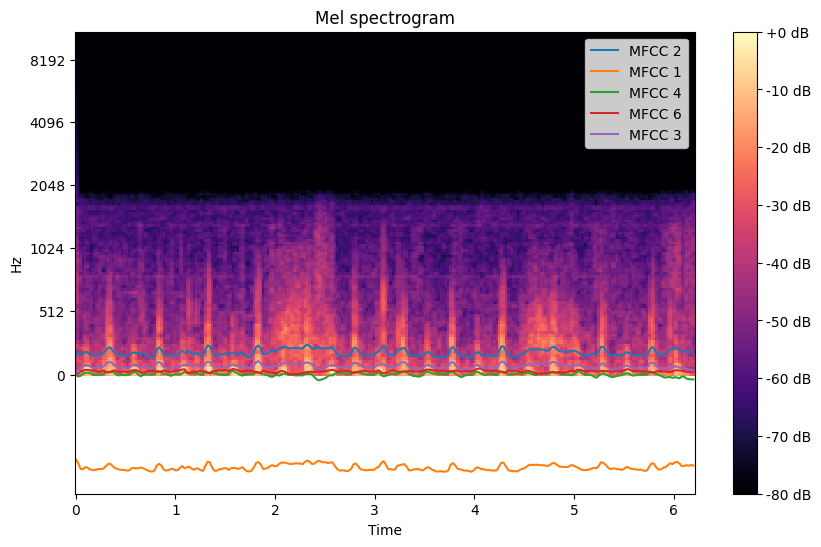

In [22]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Load the audio file
y, sr = librosa.load('/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/dataset/normals_4000/normal__103_1305031931979_B.wav')

# Compute the Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# Compute MFCCs
mfccs = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Visualize the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')
plt.title('Mel spectrogram')

# Highlight important MFCC regions
# Instead of plotting MFCCs directly, indicate their importance
for idx in important_mfcc_indices[:5]:  # Take top 5 important MFCCs for example
    mfcc_time_frames = np.arange(mfccs.shape[1])  # Time frames
    mfcc_values = mfccs[idx]  # MFCC values for the important coefficient
    plt.plot(librosa.frames_to_time(mfcc_time_frames, sr=sr), mfcc_values, label=f'MFCC {idx+1}')

plt.legend()
plt.show()


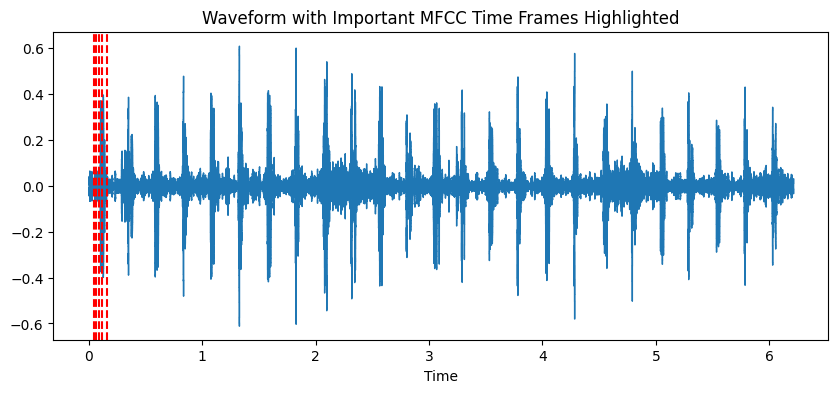

In [23]:
# Convert MFCC indices to time frames
hop_length = 512  # This should match the hop length used in MFCC computation
n_fft = 2048  # This should match the FFT window size used in MFCC computation
mfcc_times = librosa.frames_to_time(np.arange(mfccs.shape[1]), sr=sr, hop_length=hop_length, n_fft=n_fft)

# Identify the time frames corresponding to important MFCC coefficients
top_mfcc_indices = important_mfcc_indices[:5]
important_times = mfcc_times[top_mfcc_indices]

# Plot the waveform with important MFCC time frames highlighted
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
for t in important_times:
    plt.axvline(x=t, color='r', linestyle='--')

plt.title('Waveform with Important MFCC Time Frames Highlighted')
plt.show()

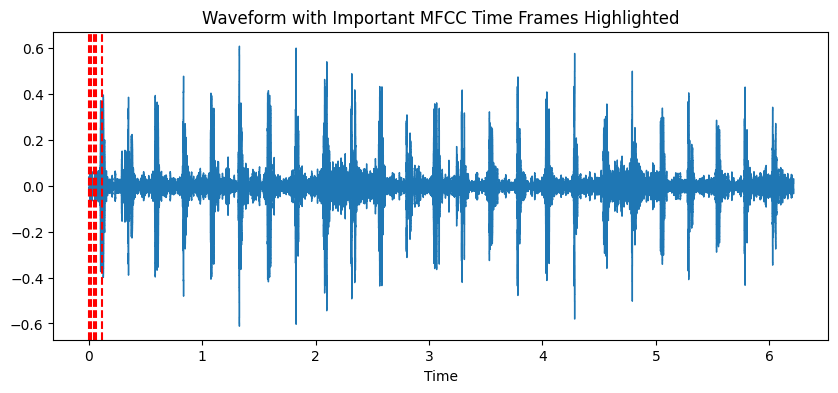

In [24]:
# Convert frame indices to time
important_times = librosa.frames_to_time(top_mfcc_indices, sr=sr, hop_length=hop_length)

# Plot the waveform with important MFCC time frames highlighted
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
for t in important_times:
    plt.axvline(x=t, color='r', linestyle='--')

plt.title('Waveform with Important MFCC Time Frames Highlighted')
plt.show()


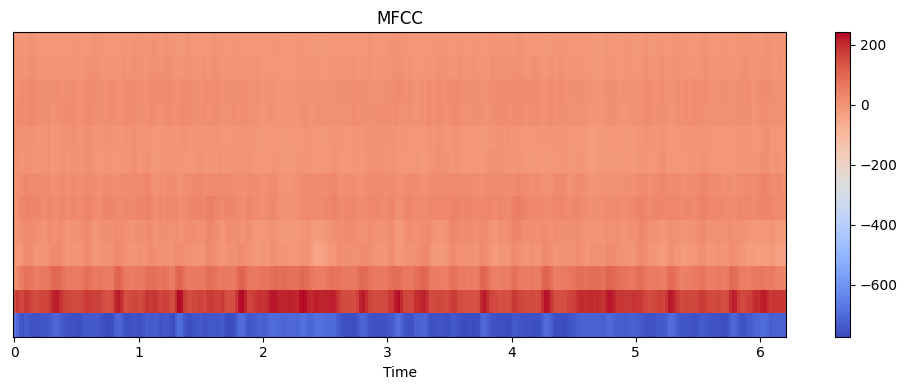

Top MFCC Indices: [1 0 3 5 2]
Important Times: [0.02321995 0.         0.06965986 0.11609977 0.04643991]


In [25]:
# Plot MFCC values to see their distribution
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# Print the important MFCC coefficients and their times
print("Top MFCC Indices:", top_mfcc_indices)
print("Important Times:", important_times)


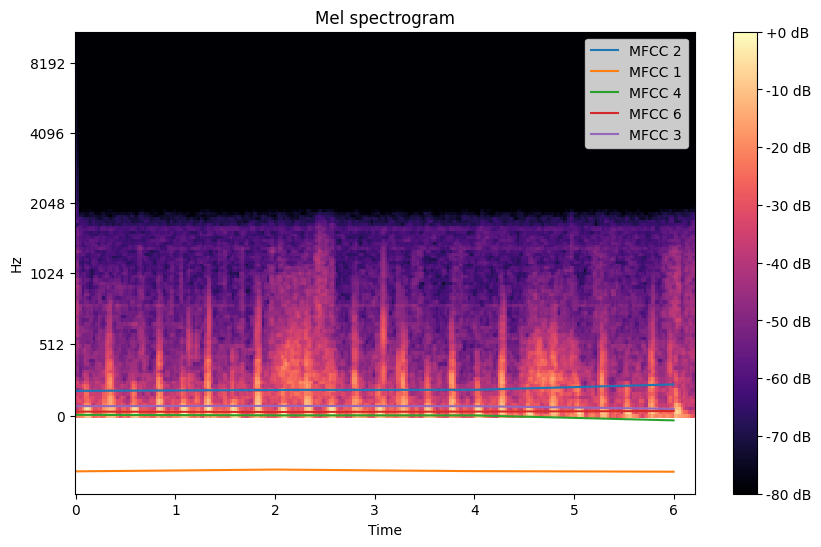

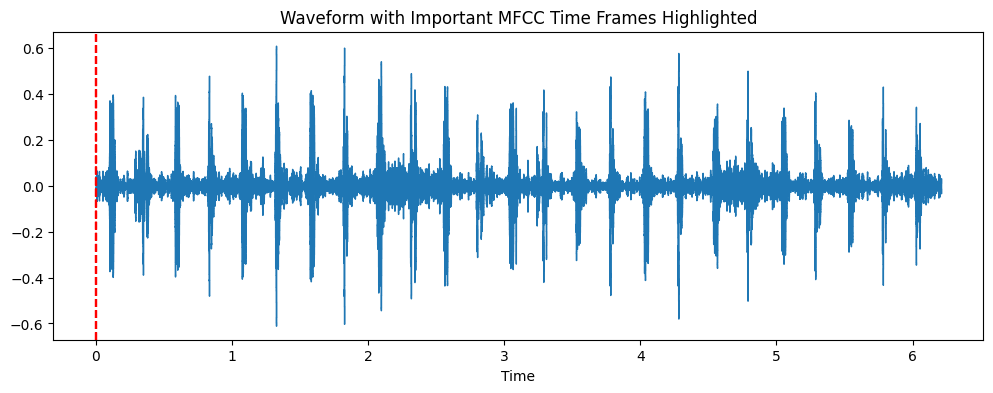

In [37]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

# Load the audio file
y, sr = librosa.load('/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/dataset/normals_4000/normal__103_1305031931979_B.wav')

# Parameters
chunk_duration = 2  # seconds
chunk_samples = int(chunk_duration * sr)
hop_length = 512
n_mfcc = 13

# Split audio into chunks
chunks = [y[i:i + chunk_samples] for i in range(0, len(y), chunk_samples)]

# Compute MFCCs for each chunk and take the average across time
mfccs_list = [librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=n_mfcc).mean(axis=1) for chunk in chunks]

# Stack MFCCs to form a feature matrix
mfccs = np.vstack(mfccs_list)

# Compute permutation importance
perm_importance = permutation_importance(model, X_train, y_train)
importance = perm_importance.importances_mean

# Identify the most important MFCC coefficients
important_mfcc_indices = np.argsort(importance)[::-1]
top_mfcc_indices = important_mfcc_indices[:5]

# Map the important MFCC indices to time frames
chunk_times = np.arange(len(chunks)) * chunk_duration
important_times = chunk_times[top_mfcc_indices // n_mfcc]

# Plot the mel spectrogram with important MFCC features highlighted
plt.figure(figsize=(10, 6))
S = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

for idx in top_mfcc_indices:
    mfcc_idx = idx % n_mfcc
    plt.plot(chunk_times, mfccs[:, mfcc_idx], label=f'MFCC {mfcc_idx+1}')
    
plt.legend(loc='upper right')
plt.show()

# Plot the waveform with important time frames highlighted
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
for t in important_times:
    plt.axvline(x=t, color='r', linestyle='--')

plt.title('Waveform with Important MFCC Time Frames Highlighted')
plt.show()


In [39]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def save_waveform_images(audio_file, output_dir, chunk_duration=2, sr=4000):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=sr)
    
    # Parameters
    chunk_samples = int(chunk_duration * sr)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each chunk
    for i in range(0, len(y), chunk_samples):
        # Extract the chunk
        chunk = y[i:i + chunk_samples]
        
        # Compute the time axis
        t = np.linspace(0, chunk_duration, len(chunk))

        # Create the plot
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(chunk, sr=sr)
        plt.title(f'Chunk {i // chunk_samples}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        # Save the plot as an image
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'chunk_{i // chunk_samples}.png')
        plt.savefig(output_path)
        plt.close()

# Example usage
audio_file = '/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/dataset/normals_4000/normal__103_1305031931979_B.wav'
output_dir = '/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/notebooks'
save_waveform_images(audio_file, output_dir)


In [58]:
# Load the audio file
y, sr = librosa.load(audio_file, sr=sr)

# Parameters
chunk_samples = int(chunk_duration * sr)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each chunk
for i in range(0, len(y), chunk_samples):
	# Extract the chunk
	chunk = y[i:i + chunk_samples]
	librosa.display.waveshow(chunk, sr=sr)
	# remove spines
	plt.gca().spines['top'].set_visible(False)
	plt.gca().spines['right'].set_visible(False)
	plt.gca().spines['left'].set_visible(False)
	plt.gca().spines['bottom'].set_visible(False)
	# remove ticks
	plt.gca().xaxis.set_ticks([])
	plt.gca().yaxis.set_ticks([])
	# remove labels
	plt.gca().set_xlabel('')
	plt.gca().set_ylabel('')
	# save the plot as an image
	output_path = os.path.join(output_dir, f'chunk_{i // chunk_samples}.png')
	plt.savefig(output_path, bbox_inches='tight', transparent=True)
	plt.close()
 

In [78]:

# load the image as array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


# Load the audio file
y, sr = librosa.load(audio_file, sr=sr)

# Parameters
chunk_samples = int(chunk_duration * sr)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each chunk
for i in range(0, len(y), chunk_samples):
	# Extract the chunk
	chunk = y[i:i + chunk_samples]
	librosa.display.waveshow(chunk, sr=sr)
	# remove spines
	plt.gca().spines['top'].set_visible(False)
	plt.gca().spines['right'].set_visible(False)
	plt.gca().spines['left'].set_visible(False)
	plt.gca().spines['bottom'].set_visible(False)
	# remove ticks
	plt.gca().xaxis.set_ticks([])
	plt.gca().yaxis.set_ticks([])
	# remove labels
	plt.gca().set_xlabel('')
	plt.gca().set_ylabel('')
	# save the plot as an image
	output_path = os.path.join(output_dir, f'chunk_{i // chunk_samples}.png')
	plt.savefig(output_path, bbox_inches='tight', transparent=True)
	plt.close()

img = mpimg.imread('/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/notebooks/chunk_0.png')
img_rgb = img[:, :, :3]  # Remove the alpha channel

# resize the image
img_resized = cv2.resize(img_rgb, (224, 224))

(224, 224, 3)